In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from os import path
from glob import glob

In [2]:
def get_filepath(city_state):
    return f"..\data\\ndvi\{city_state}.csv"

def get_city_state(filepath):
    return filepath.split("\\")[-1].split(".")[0] 

cities_df = pd.read_csv("..\data\most-populous-us-cities.csv", index_col=False)
all_ndvi_filepaths = glob("..\data\\ndvi\*")
cities_df.head()


,Cities,States,Abbreviation
0,New York,New York,NY
1,Los Angeles,California,CA
2,Chicago,Illinois,IL
3,Houston,Texas,TX
4,Phoenix,Arizona,AZ


In [3]:
N = 50
selected_filepaths = []

for city,state in zip(cities_df["Cities"].values[:N], cities_df["Abbreviation"].values[:N]):
    selected_filepaths.append(get_filepath(f"{city}-{state}"))


In [4]:
DATA = []

for i, filepath in enumerate(selected_filepaths):
    downloaded_csv = pd.read_csv(filepath)
    downloaded_csv['month-year'] = pd.to_datetime(downloaded_csv['month-year'], format = "%Y-%m-%d")
    DATA.append([get_city_state(filepath), downloaded_csv])

In [5]:
DATA[:2]

[['New York-NY',
           NDVI month-year    landsat
  0    0.216114 1984-06-01  LANDSAT 5
  1    0.257765 1984-07-01  LANDSAT 5
  2    0.245329 1984-08-01  LANDSAT 5
  3    0.238415 1984-09-01  LANDSAT 5
  4    0.186153 1984-10-01  LANDSAT 5
  ..        ...        ...        ...
  432  0.208178 2021-08-01  LANDSAT 7
  433  0.184347 2021-09-01  LANDSAT 7
  434  0.128276 2021-10-01  LANDSAT 7
  435  0.100240 2021-11-01  LANDSAT 7
  436  0.044028 2021-12-01  LANDSAT 7
  
  [437 rows x 3 columns]],
 ['Los Angeles-CA',
           NDVI month-year    landsat
  0    0.136059 1984-03-01  LANDSAT 5
  1    0.171621 1984-04-01  LANDSAT 5
  2    0.211589 1984-05-01  LANDSAT 5
  3    0.149390 1984-06-01  LANDSAT 5
  4    0.079884 1984-07-01  LANDSAT 5
  ..        ...        ...        ...
  423  0.127901 2021-08-01  LANDSAT 7
  424  0.183158 2021-09-01  LANDSAT 7
  425  0.090166 2021-10-01  LANDSAT 7
  426  0.122517 2021-11-01  LANDSAT 7
  427  0.015022 2021-12-01  LANDSAT 7
  
  [428 rows x 3 co

### Analyzing NDVI changes by year

In [6]:
yearly_df = []

for i in range(len(DATA)):
    year_avg = DATA[i][1].groupby(pd.Grouper(key = 'month-year', freq = '1Y')).mean()
    
    years = year_avg.index.year
    NDVI = year_avg.values.flatten()
    
    temp = pd.DataFrame({'Year': years, 'NDVI': NDVI})
    
    yearly_df.append((DATA[i][0], temp))

In [7]:
start = 1984
end = 2021

changes = []

for i in range(len(yearly_df)):
    _city = yearly_df[i][0]
    _data = yearly_df[i][1]
    
    try:
        m, b = np.polyfit(_data['Year'], _data['NDVI'], 1)
        change = m * (end-start)
        changes.append([_city, change])
    except:
        pass
    
sorted_change = sorted(changes, key = lambda tup:tup[1], reverse = True)

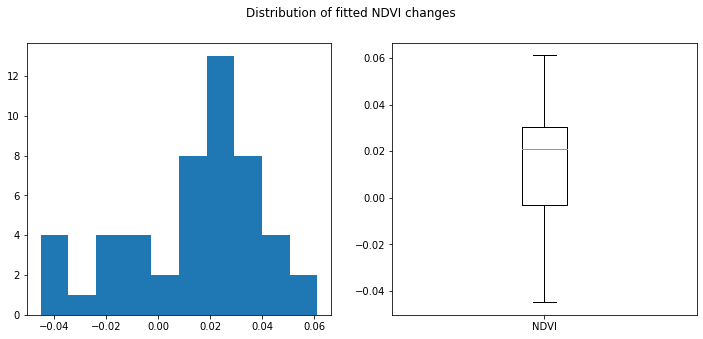

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

changes = [_d[1] for _d in sorted_change]

axs[0].hist(changes)

axs[1].boxplot(changes)
axs[1].set_xticks([1], ["NDVI"])

plt.suptitle("Distribution of fitted NDVI changes")
plt.show()

# change = slope of the n.m. * (end - start) 

#### Most Positive Changes

In [9]:
top_positive = sorted_change[:3]
top_positive

[['Dallas-TX', 0.06117409031714453],
 ['Austin-TX', 0.059796715950944095],
 ['Detroit-MI', 0.04725715036261911]]

In [10]:
top_positive_idx = []

for city, change in top_positive:
    top_positive_idx.append(selected_filepaths.index(get_filepath(city)))

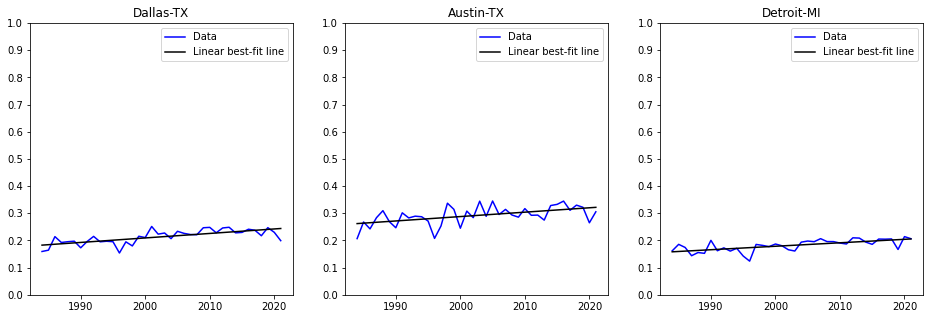

In [11]:
def plot_yearly_changes(indexes):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

    for i,idx in enumerate(indexes):
        city = yearly_df[idx][0]
        _df = yearly_df[idx][1]
        
        x = _df['Year']
        y = _df['NDVI']
        
        axs[i].plot(x, y, color = 'blue', label = 'Data')
        m, b = np.polyfit(x, y, 1)
        axs[i].plot(x, m*x+b, color = 'black', label = 'Linear best-fit line')
        axs[i].legend()
        axs[i].set_title(city)
        axs[i].set_yticks(np.linspace(0, 1, 11))

    plt.show()

plot_yearly_changes(top_positive_idx)

#### Most negative changes

In [12]:
top_negative = sorted_change[-4:-1]
top_negative

[['El Paso-TX', -0.036824418709644896],
 ['Denver-CO', -0.04052279720122811],
 ['Omaha-NE', -0.04450401766072368]]

In [13]:
top_negative_idx = []

for city, change in top_negative:
    top_negative_idx.append(selected_filepaths.index(get_filepath(city)))

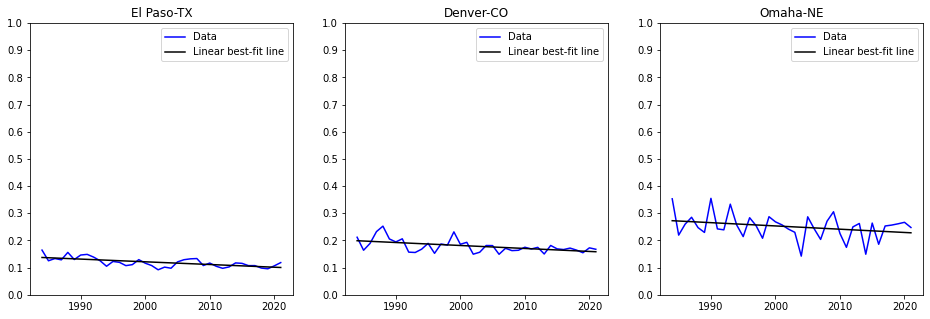

In [14]:
plot_yearly_changes(top_negative_idx)

### Analyzing NDVI changes for a specific month over the years

In [15]:
def get_monthly_df(month):
    month_data = []
    
    for i in range(len(DATA)):
        _city = DATA[i][0]
        _df = DATA[i][1]

        _filter = _df['month-year'].dt.month.between(month,month)
        df_month = _df[_filter]

        ndvi = df_month["NDVI"].values.flatten()
        dates = df_month["month-year"].values.flatten()

        temp = pd.DataFrame({'month-year':dates, "NDVI":ndvi})

        month_data.append([_city, temp])
    
    return month_data

def fit_linear_model(monthly_changes, start=1984, end=2021):
    changes = []

    for i in range(len(monthly_changes)):
        _city = monthly_changes[i][0]
        _data = monthly_changes[i][1]
        
    
        m, b = np.polyfit([i for i in range(len(_data["NDVI"]))], _data['NDVI'], 1)
        change = m * (end-start)
        changes.append((_city, change))
    
        
    sorted_change = sorted(changes, key = lambda tup:tup[1], reverse = True)

    return sorted_change

def get_idxs(top_changes):
    top_changes_idx = []

    for city, change in top_changes:
        top_changes_idx.append(selected_filepaths.index(get_filepath(city)))

    return top_changes_idx

def plot_monthly_changes(data_month, indexes, month, isPositive=True):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

    for i, idx in enumerate(indexes):
        _city = data_month[idx][0]
        _data = data_month[idx][1]

        x = np.array([k for k in range(len(_data["NDVI"]))])
        y = _data["NDVI"]

        
        axs[i].plot(_data["month-year"], y, color = 'blue', label = 'Data')
        m, b = np.polyfit(x, y, 1)
        axs[i].plot(_data["month-year"], m*x+b, color = 'black', label = 'Linear best-fit line')
        axs[i].legend()
        axs[i].set_title(_city)
        axs[i].set_yticks(np.linspace(0, 1, 11))

    change_type = "positive" if isPositive else "negative"
    plt.suptitle(f"Top 3 most {change_type} changes for the month: {month}")
    plt.show()

def plot_overall_distribution(sorted_change, month):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

    changes = [_d[1] for _d in sorted_change]

    axs[0].hist(changes)

    axs[1].boxplot(changes)
    axs[1].set_xticks([1], ["NDVI"])

    plt.suptitle(f"Distribution of fitted NDVI average changes for the month: {month}")
    plt.show()
    

In [16]:
data_july = get_monthly_df(7)
data_july[:1]

[['New York-NY',
     month-year      NDVI
  0  1984-07-01  0.257765
  1  1985-07-01  0.053011
  2  1986-07-01  0.169500
  3  1987-07-01  0.208602
  4  1988-07-01  0.128271
  5  1989-07-01  0.152351
  6  1990-07-01  0.210312
  7  1991-07-01  0.148415
  8  1992-07-01  0.190968
  9  1993-07-01  0.152138
  10 1994-07-01  0.151192
  11 1995-07-01  0.166861
  12 1996-07-01  0.144664
  13 1997-07-01  0.058038
  14 1998-07-01  0.239209
  15 1999-07-01  0.150723
  16 2000-07-01  0.186310
  17 2001-07-01  0.200050
  18 2002-07-01  0.173877
  19 2003-07-01  0.299765
  20 2004-07-01  0.169289
  21 2005-07-01  0.166546
  22 2006-07-01  0.207948
  23 2007-07-01  0.156638
  24 2008-07-01  0.195260
  25 2009-07-01  0.214052
  26 2010-07-01  0.146713
  27 2011-07-01  0.184426
  28 2012-07-01  0.194490
  29 2013-07-01  0.145472
  30 2014-07-01  0.229292
  31 2015-07-01  0.205563
  32 2016-07-01  0.185697
  33 2017-07-01  0.232158
  34 2018-07-01  0.212741
  35 2019-07-01  0.182362
  36 2020-07-01  0.16

In [17]:
changes_july = fit_linear_model(data_july)

top_positive = changes_july[:3]
top_positive

[('Nashville-TN', 0.11574622970114373),
 ('Indianapolis-IN', 0.11117522762092891),
 ('Milwaukee-WI', 0.1036001108144159)]

In [18]:
def show_top_k_changes(month):
    data_month = get_monthly_df(month)
    sorted_change = fit_linear_model(data_month)

    plot_overall_distribution(sorted_change, month)
    
    top_positive = sorted_change[:3]
    top_positive_idx = get_idxs(top_positive)
    plot_monthly_changes(data_month, top_positive_idx, month)

    top_negative = sorted_change[-4:-1]
    top_negative_idx = get_idxs(top_negative)
    plot_monthly_changes(data_month, top_negative_idx, month, False)


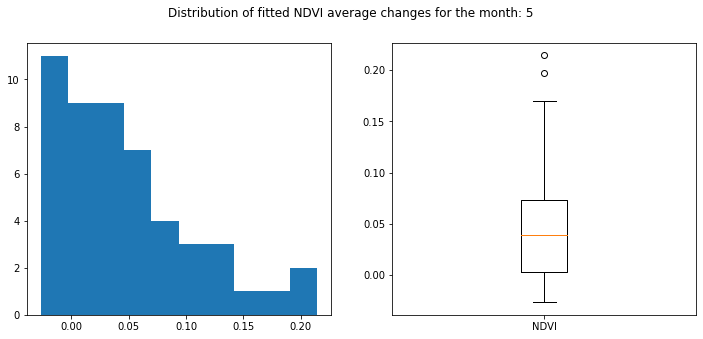

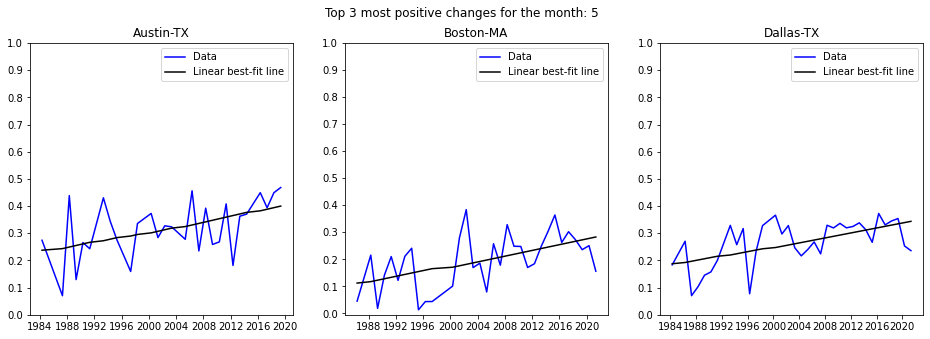

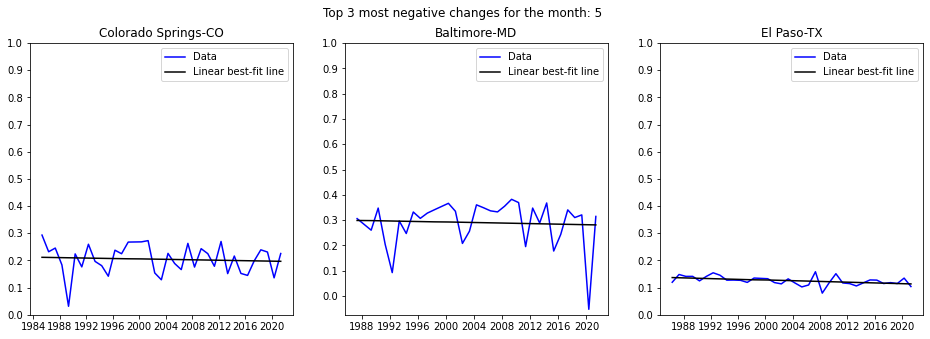

In [19]:
show_top_k_changes(5)

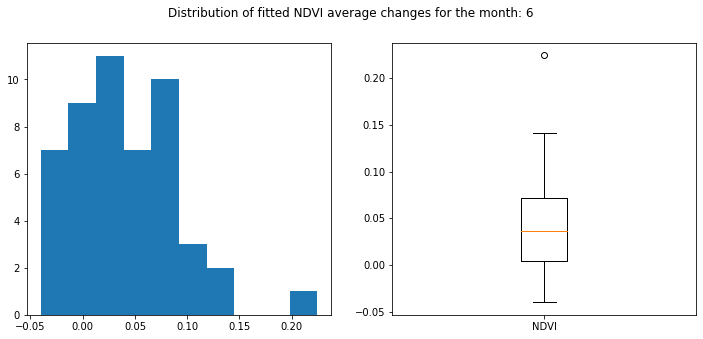

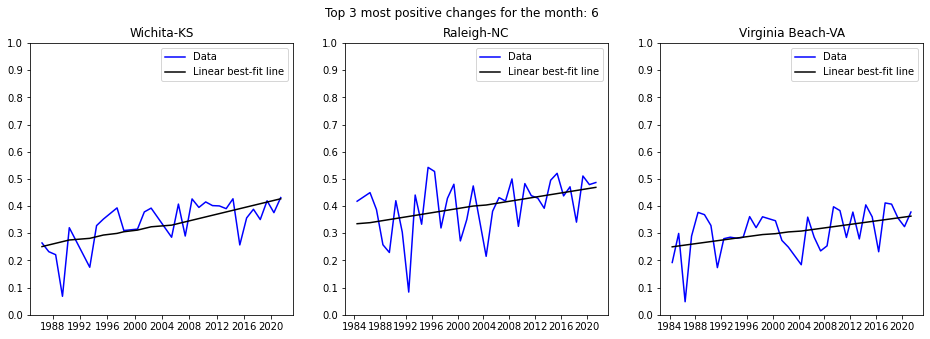

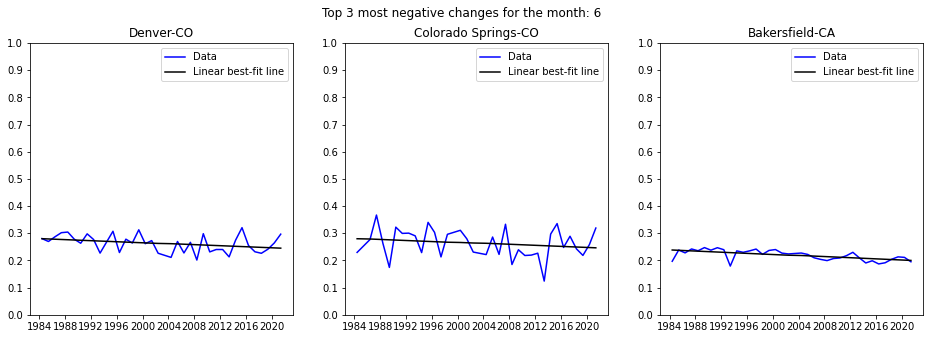

In [20]:
show_top_k_changes(6)

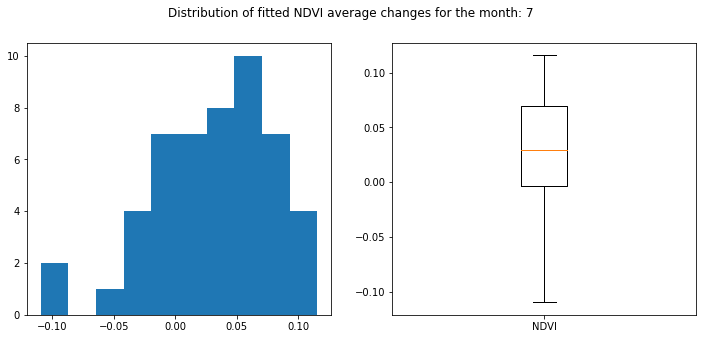

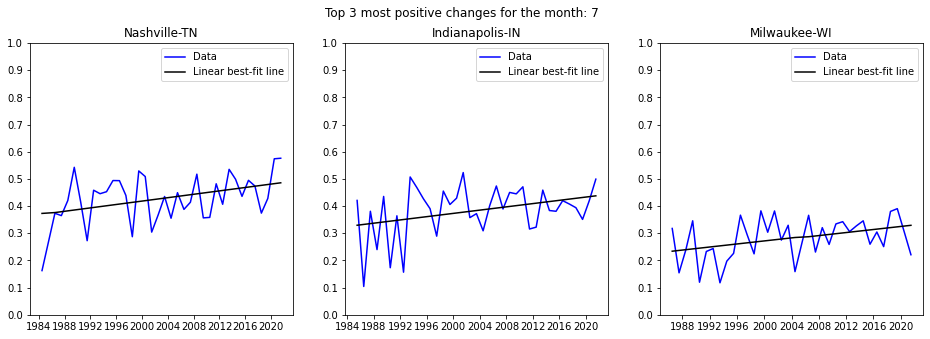

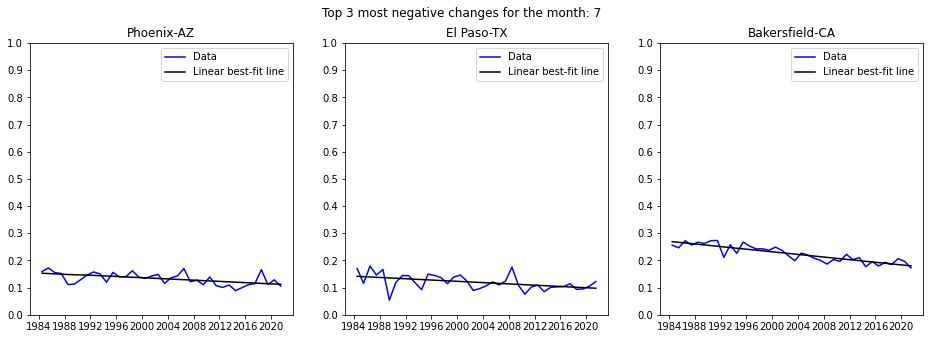

In [21]:
show_top_k_changes(7)

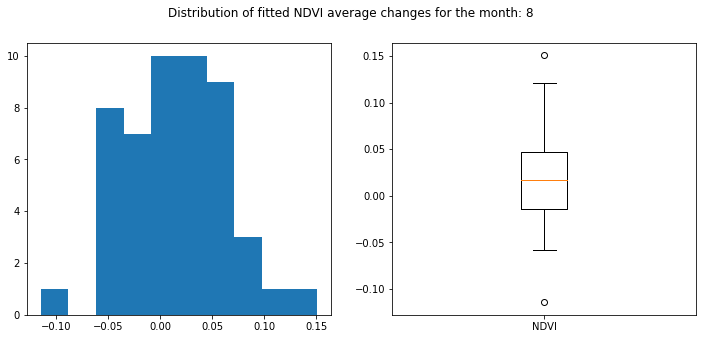

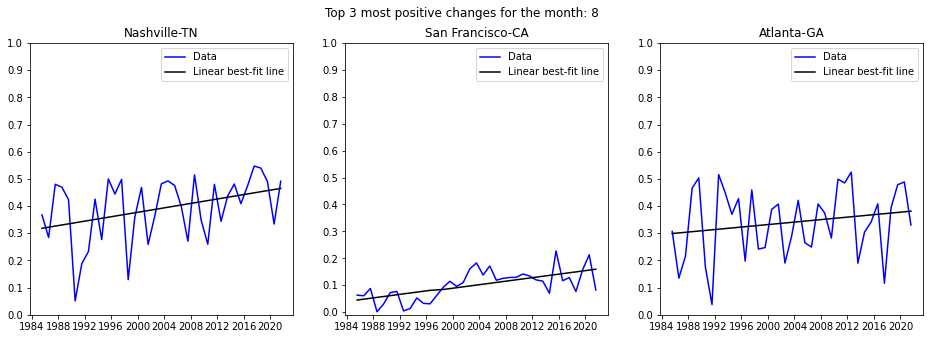

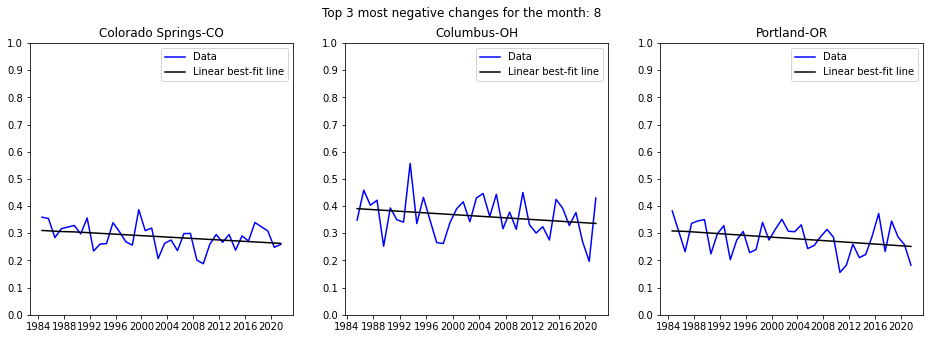

In [22]:
show_top_k_changes(8)